In [33]:
# Import library and download datasets

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")

    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)

        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)

        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path='datasets')

    return pd.read_csv(Path("datasets/housing/housing.csv"))
    

In [34]:
# Load the data
df_housing = load_housing_data()
df_housing.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [35]:
df_housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [36]:
# util
import numpy as np
from zlib import crc32


# function for splitting data into train and test sets
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# another ways to split data using id hash
def is_id_in_test_set(id, test_ratio):
    return crc32(np.int64(id)) & 0xffffffff < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [37]:
# split data into train and test sets using shuffle
train_set, test_set = shuffle_and_split_data(df_housing, 0.2)
display("Train Data Shuffle: "+str(len(train_set)))
display("Test Data Shuffle: "+str(len(test_set))) 

# split data into train and test sets using id hash
df_housing_with_id = df_housing.reset_index()
train_set, test_set = split_data_with_id_hash(df_housing_with_id, 0.2, "index")
display("Train Data Hash: "+str(len(train_set)))
display("Test Data Hash: "+str(len(test_set)))

'Train Data Shuffle: 16512'

'Test Data Shuffle: 4128'

'Train Data Hash: 16512'

'Test Data Hash: 4128'

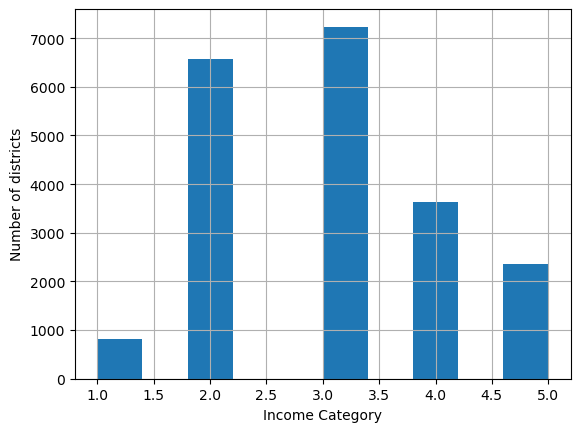

In [38]:
# creating income category attribute
df_housing["income_cat"] = pd.cut(df_housing["median_income"],
                                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                    labels=[1, 2, 3, 4, 5])

import matplotlib.pyplot as plt

# df_housing["income_cat"].value_counts().sort_index().plot.bar(rot=0 ,grid=True)
df_housing["income_cat"].hist()
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [39]:
# Split data into train and test sets using stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in split.split(df_housing, df_housing["income_cat"]):
    strat_train_set_n = df_housing.loc[train_index]
    strat_test_set_n = df_housing.loc[test_index]
    strat_splits.append((strat_train_set_n, strat_test_set_n))

strat_train_set, strat_test_set = strat_splits[0]
display("Train Data Stratified: "+str(len(strat_train_set)))
display("Test Data Stratified: "+str(len(strat_test_set)))

strat_train_set, strat_test_set = train_test_split(df_housing, 
                                                   test_size=0.2, 
                                                   random_state=42, 
                                                   stratify=df_housing["income_cat"])
display("Train Data Split: "+ str(len(strat_train_set)))
display("Test Data Split: "+ str(len(strat_test_set)))

'Train Data Stratified: 16512'

'Test Data Stratified: 4128'

'Train Data Split: 16512'

'Test Data Split: 4128'

In [40]:
# remove income_cat attribute
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [41]:
# show in scater longitude and latitude
housing = strat_train_set.copy()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


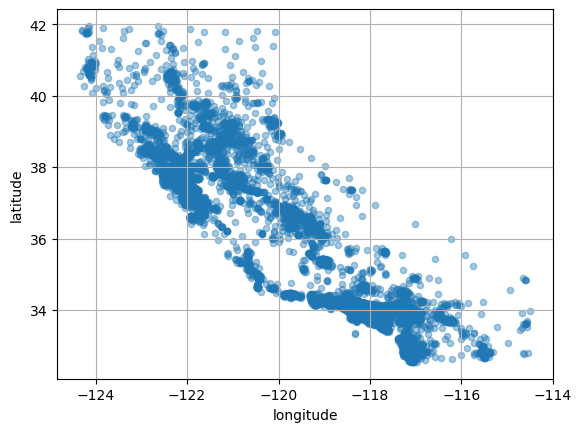

In [42]:

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, grid=True)
plt.show()

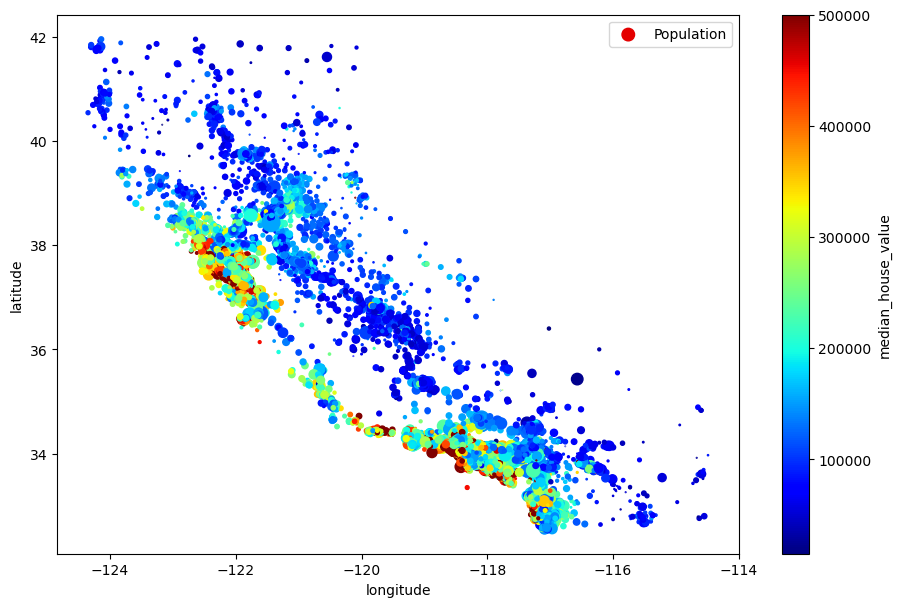

In [43]:
housing.plot(kind="scatter", x="longitude", y="latitude",
             s=housing["population"]/100, label="Population",
                c="median_house_value", cmap='jet',colorbar=True,
                legend=True, sharex=False, figsize=(11,7))
plt.show()

In [44]:
# looking for correlations
h = housing.copy() 
h.drop("ocean_proximity", axis=1, inplace=True)
corr_matrix = h.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

<Axes: xlabel='median_income', ylabel='median_house_value'>

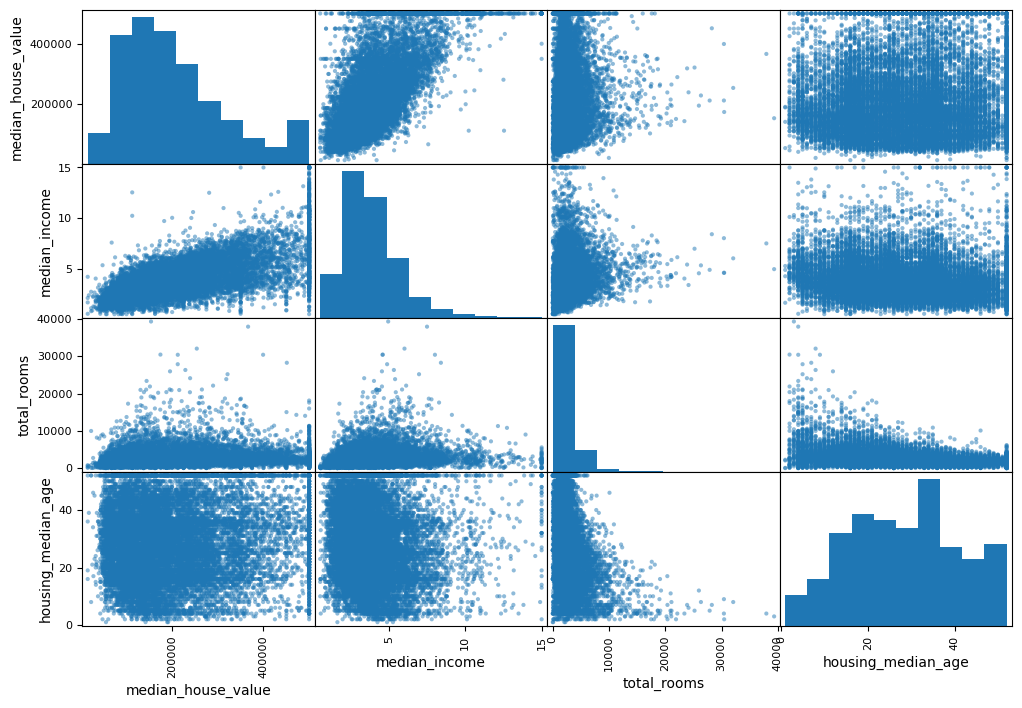

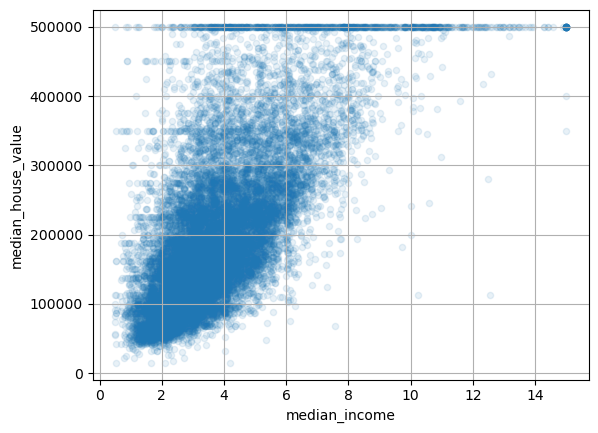

In [45]:
# ways to check correlation
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
                "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12,8))

housing.plot(kind="scatter",
             x="median_income",
             y="median_house_value",
             alpha=0.1,
             grid=True)


In [46]:
# correlation between attributes
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_household"] = housing["population"]/housing["households"]

corr_matrix = h.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

In [47]:
# preparation data for machine learning algorithms
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# data cleaning

housing.dropna(subset=["total_bedrooms"]) # option 1
housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

# using SimpleImputer is better way to fill missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
display(imputer.statistics_)
display(housing_num.median().values)


X = imputer.transform(housing_num)

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [48]:
# Return the result to a pandas DataFrame.
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)


In [49]:
housing_cat = housing[["ocean_proximity"]]

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import rbf_kernel

# tranform categorical attributes to numerical
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

display(housing_cat_encoded[:10])
# show categories
display(ordinal_encoder.categories_)

# one hot encoding
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
display(housing_cat_1hot)

# custom transformer
df_test = pd.DataFrame({"ocean_proximity": ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]})
pd.get_dummies(df_test)


min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
display(housing_num_min_max_scaled)

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)



array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]])

In [51]:
from sklearn.linear_model import LinearRegression


target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

m = LinearRegression()
m.fit(housing[['median_income']], scaled_labels)
some_new_data = housing[['median_income']].iloc[:5]

scaled_predictions = m.predict(some_new_data)
predicctions = target_scaler.inverse_transform(scaled_predictions)
print(predicctions)

[[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]


In [52]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predicctions = model.predict(some_new_data)
display(predicctions)

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [53]:
# costum Transformers

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

display(log_pop[:5])

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905


In [54]:
from sklearn.preprocessing import FunctionTransformer

rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])

display(age_simil_35[:5])

sf_coord = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coord], gamma=0.1)) 
sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])

display(sf_simil)

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       [8.48904403e-15],
       [9.04837418e-01]])

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [55]:
#Custom transformeer class

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean
        self.mean_ = None
        self.scale_ = None

    def fit(self, X, y=None): # y is required even though we don't use it
        X = check_array(X, dtype=np.number) # check that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit()
        return self

    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes
        X = check_array(X, dtype=np.number)
        assert self.n_features_in_ == X.shape[1] # check that the number of columns is the same
        if self.with_mean:
            X = X - self.mean_
        return X  / self.scale_
    


In [56]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
        
    def transform(self,x):
        return rbf_kernel(x, self.kmeans_.cluster_centers_, gamma=self.gamma)
        
    def get_features_names_out(self):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [57]:
# use clusterSimilarity
cluster_similarity = ClusterSimilarity(n_clusters=5, gamma=0.1, random_state=42)
similarities = cluster_similarity.fit_transform(housing[['latitude', 'longitude']], sample_weight=housing_labels)

display(similarities[:5].round(2))


array([[0.04, 0.99, 0.01, 0.3 , 0.8 ],
       [0.99, 0.07, 0.74, 0.67, 0.03],
       [0.03, 0.95, 0.01, 0.28, 0.94],
       [0.89, 0.02, 0.95, 0.35, 0.01],
       [0.99, 0.05, 0.84, 0.55, 0.02]])

In [58]:
# Transformation Pipelines
from sklearn import set_config
from sklearn.pipeline import Pipeline, make_pipeline


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

# active diagram estimator
set_config(display='diagram')

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

housing_num_tr = num_pipeline.fit_transform(housing_num)
display(housing_num_tr[:5].round(2))



array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17],
       [-1.2 ,  1.28,  0.35, -0.71, -0.76, -0.79, -0.78, -0.76],
       [ 1.23, -0.88, -0.92,  0.7 ,  0.74,  0.38,  0.73, -0.85],
       [ 0.71, -0.88,  0.59,  0.79,  1.6 ,  0.44,  1.76, -0.18]])

In [65]:
# compose many pipelines

from sklearn.compose import ColumnTransformer

num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']
cat_attribs = ['ocean_proximity']


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), 
    OneHotEncoder(handle_unknown='ignore'))

# compose many pipelines
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)])

# other wait to compose pipelines selection columns

from sklearn.compose import make_column_selector, make_column_transformer

mk_preprocessor = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)))

housing_prepared = full_pipeline.fit_transform(housing)

mk_housing_prepared = mk_preprocessor.fit_transform(housing)

In [71]:
#  utisl code
from sklearn import set_config

def column_ratio(X):
    return X[:, 0] / X[:, 1]

def ratio_name(func_transformer, feature_names_in):
    return ['ratio']

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, 
                                  gamma=0.1, 
                                  random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                                     StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

housing_prepared = preprocessing.fit_transform(df_housing)
# display(housing_prepared.shape)
# display(housing_prepared.get_feature_names_out())



In [ ]:
# selection modelo

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)
housing_labels.iloc[:5].values


lin_rmse = mean_squared_error(housing_labels, 
                              housing_predictions, 
                              squared=False)



tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, 
                               housing_predictions, 
                               squared=False)

In [ ]:
# validation model

from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)

pd.Series(tree_rmses).describe()